# Build a Multi-Omics Container for GCN Training
The goal of this little notebook is to create one HDF5 container that contains a feature matrix consisting of our multi-omics data:
* Mutation Frequencies
* Gene Expression
* Methylation

We then can train our network using the iref or CPDB PPI together with the multi-omics information.

In [1]:
import h5py, sys, os
import re
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import mygene


sys.path.append(os.path.abspath('../../GCN'))
import gcnPreprocessing
import gcnIO
plt.rc('font', family='Times New Roman')
%matplotlib inline

## Parameters
* `use_quantile_norm`: Normalize the data with (normal) quantile normalization instead of simple MinMax normalization
* `ppi_network_to_use`: Which underlying PPI network to use (can be [CPDB](http://cpdb.molgen.mpg.de/CPDB), [IREF](http://irefindex.org/wiki/index.php?title=iRefIndex) , Multinet or [STRING](https://string-db.org/))
* `remove_blood_cancer_genes`: Whether or not to remove blood cancer genes according to [COSMIC CGC](https://cancer.sanger.ac.uk/cosmic/download) from the positive labels (known cancer genes) or not (True for removal, False otherwise)
* `cna_as_separate_omics`: Whether or not copy number changes (as determined by GISTIC 2) are added to the SNV information or treated as separate data set
* `use_mutsigcv_scores`: Uses the $-log_{10}$ q-values from MutSigCV instead of the simple counts of SNVs per gene
* `label_source`: Which source to use for the positive labels (known cancer genes). This can come from either the [NCG](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1612-0) or a literature mining approach called [DigSEE](http://210.107.182.61/digseeOld/). While the NCG known cancer genes represent a manually curated list with pan-cancer genes, this source is highly biased to over-studied genes and mutations. DigSEE genes, on the other hand, are only mined from PubMed abstracts and therefore much less reliable but on the other hand less biased. DigSEE enables to look for the evidence that leads to a cancer and therefore options for this variable are: _NCG_, _expression_, _methylation_, _mutation_
* `use_cnas`: Whether or not to integrate copy number information in the data (either as separate -omics or added to the SNVs similar to HotNet2, determined by `cna_as_separate_omics`)

In [3]:
# PARAMETERS
use_quantile_norm = False # quantile or MinMax normalization
ppi_network_to_use ='STRING'
remove_blood_cancer_genes = False
cna_as_separate_omics = False
use_mutsigcv_scores = False
use_cnas = True
label_source = 'all'
minimum_degree_negatives = 1

## Functions

In [4]:
def get_gene_symbols(list_of_ensembl_ids):
    # get Ensembl IDs for gene names
    mg = mygene.MyGeneInfo()
    res = mg.querymany(list_of_ensembl_ids,
                       scopes='ensembl.gene',
                       fields='symbol',
                       species='human', returnall=True
                      )

    def get_symbol_and_ensembl(d):
        if 'symbol' in d:
            return [d['query'], d['symbol']]
        else:
            return [d['query'], None]

    node_names = [get_symbol_and_ensembl(d) for d in res['out']]
    # now, retrieve the names and IDs from a dictionary and put in DF
    node_names = pd.DataFrame(node_names, columns=['Ensembl_ID', 'Symbol']).set_index('Ensembl_ID')
    node_names.dropna(axis=0, inplace=True)
    return node_names

def get_ensembl_ids(list_of_gene_symbols):
    # get Ensembl IDs for gene names
    mg = mygene.MyGeneInfo()
    res = mg.querymany(list_of_gene_symbols,
                       scopes='symbol, refseq, uniprot',
                       fields='ensembl.gene',
                       species='human', returnall=True
                      )

    # now, retrieve the names and IDs from a dictionary and put in DF
    def get_name_and_id(x):
        if 'ensembl' in x:
            ens_id = x['ensembl'][0]['gene'] if type(x['ensembl']) is list else x['ensembl']['gene']
            symbol = x['query']
            return [symbol, ens_id]
        else:
            return [x['query'], None]

    ens_ids = [get_name_and_id(x) for x in res['out']]
    
    node_names = pd.DataFrame(ens_ids, columns=['Symbol', 'Ensembl_ID']).set_index('Ensembl_ID')
    node_names.dropna(axis=0, inplace=True)
    node_names.drop_duplicates(inplace=True)
    return node_names

## Load the data from disk and unify

In [7]:
# Load mutation data
if use_mutsigcv_scores:
    snvs = pd.read_csv('../../data/pancancer/mutsigcv/mutsigcv_genescores.csv', sep='\t')
    snvs.columns = ['Name'] + snvs.columns.tolist()[1:]
    snvs.set_index('Name', inplace=True)
else:
    if use_cnas and not cna_as_separate_omics:
        snvs = pd.read_csv('../../data/pancancer/TCGA/mutation/mutfreq_mean.tsv', sep='\t')
    else:
        snvs = pd.read_csv('../../data/pancancer/TCGA/mutation/snvs_mean.tsv', sep='\t')
    snvs.set_index('Name', inplace=True)
    snvs.columns = ['Ensembl_ID'] + snvs.columns[1:].tolist()

# Load methylation
methylation = pd.read_csv('../../data/pancancer/TCGA/methylation/methylation_RATIO_mean.tsv', sep='\t')
methylation.columns = ['Name'] + [i.upper() for i in methylation.columns[1:]]
methylation.set_index('Name', inplace=True)

# Load expression
expression = pd.read_csv('../../data/pancancer/TCGA/expression/expression_fixed_mean.tsv', sep='\t')
#expression = pd.read_csv('../../data/pancancer/TCGA/expression/expression_mean_counts_gtexnormal.tsv', sep='\t')
expression.columns = ['Name'] + [i.upper() for i in expression.columns[1:]]
expression.set_index('Name', inplace=True)

# load CNAs
cnas = pd.read_csv('../../data/pancancer/TCGA/mutation/firehose_cnas_meancancertypes_20160128.tsv', sep='\t')
cnas.columns = ['Name'] + [i.upper() for i in cnas.columns[1:]]
cnas.set_index('Name', inplace=True)

# Load PPI network
ppi_network = None
if ppi_network_to_use.upper() == 'IREF':
    net_file = '../../data/pancancer/hotnet2/networks/irefindex9/irefindex9_edge_list'
    name_file = '../../data/pancancer/hotnet2/networks/irefindex9/irefindex9_index_gene'
    edgelist = pd.read_csv(net_file, sep=' ', header=None,
                           names=['from', 'to', 'weight'])
    index = pd.read_csv(name_file, sep=' ', header=None, names=['name'])
    # build network and relabel nodes to match with real names
    ppi_graph = nx.from_pandas_edgelist(edgelist, source='from', target='to', edge_attr=None)
    _ = nx.relabel_nodes(ppi_graph, index.to_dict()['name'], copy=False)
    ppi_network = nx.to_pandas_adjacency(G=ppi_graph)
    symbols_network_genes = get_ensembl_ids(ppi_network.index)
    # Remove nodes from network that don't have corresponding gene names
    nodes_not_translatable = ppi_network[~ppi_network.index.isin(symbols_network_genes.Symbol)].index
    print ("Not translatable: {}".format(nodes_not_translatable.shape[0]))
    ppi_graph.remove_nodes_from(nodes_not_translatable)
    ppi_network = nx.to_pandas_adjacency(G=ppi_graph)
    assert ((ppi_network.index == symbols_network_genes.Symbol).all())
elif ppi_network_to_use.upper() == 'MULTINET':
    net_file = '../../data/pancancer/hotnet2/networks/multinet/multinet_edge_list'
    name_file = '../../data/pancancer/hotnet2/networks/multinet/multinet_index_gene'
    edgelist = pd.read_csv(net_file, sep=' ', header=None,
                           names=['from', 'to', 'weight'])
    index = pd.read_csv(name_file, sep=' ', header=None, names=['name'])
    # build network and relabel nodes to match with real names
    ppi_graph = nx.from_pandas_edgelist(edgelist, source='from', target='to', edge_attr=None)
    _ = nx.relabel_nodes(ppi_graph, index.to_dict()['name'], copy=False)
    ppi_network = nx.to_pandas_adjacency(G=ppi_graph)
    symbols_network_genes = get_ensembl_ids(ppi_network.index)
    # Remove nodes from network that don't have corresponding gene names
    nodes_not_translatable = ppi_network[~ppi_network.index.isin(symbols_network_genes.Symbol)].index
    print ("Not translatable: {}".format(nodes_not_translatable.shape[0]))
    ppi_graph.remove_nodes_from(nodes_not_translatable)
    ppi_network = nx.to_pandas_adjacency(G=ppi_graph)
elif ppi_network_to_use.upper() == 'CPDB':
    ppi_network = pd.read_csv('../../data/networks/CPDB_symbols_edgelist.tsv', sep='\t')
    ppi_graph = nx.from_pandas_edgelist(df=ppi_network, source='partner1', target='partner2', edge_attr='confidence')
    ppi_network = nx.to_pandas_adjacency(G=ppi_graph)
elif ppi_network_to_use.upper() == 'STRING':
    ppi_network = pd.read_csv('../../data/networks/string_SYMBOLS_highconf.tsv', sep='\t', compression='gzip')
    ppi_graph = nx.from_pandas_edgelist(df=ppi_network, source='partner1', target='partner2', edge_attr='confidence')
    ppi_network = nx.to_pandas_adjacency(G=ppi_graph)
else:
    print ("No PPI network named {}".format(ppi_network_to_use))

print ("Edges: {}\tNodes: {}".format(ppi_graph.number_of_edges(), ppi_graph.number_of_nodes()))

# Next, I have to remove cancer types only present in a subset of the data
relevant_ctypes = list(set(snvs.columns[1:]).intersection(*[set(expression.columns), set(methylation.columns), set(cnas.columns)]))
snvs = snvs[relevant_ctypes]
methylation = methylation[relevant_ctypes]
expression = expression[relevant_ctypes]
cnas = cnas[relevant_ctypes]

# Finally, reindex to the network nodes such that everything is in the same order and non-network genes are removed
snvs_ppiindex = snvs.reindex(ppi_network.index, fill_value=0)
methylation_ppiindex = methylation.reindex(ppi_network.index, fill_value=0)
expression_ppiindex = expression.reindex(ppi_network.index, fill_value=0)
cna_ppiindex = cnas.reindex(ppi_network.index, fill_value=0)

# print some stats
mut_nodes = snvs[snvs.index.isin(ppi_network.index)].shape[0]
meth_nodes = methylation[methylation.index.isin(ppi_network.index)].shape[0]
ge_nodes = expression[expression.index.isin(ppi_network.index)].shape[0]
cna_nodes = cnas[cnas.index.isin(ppi_network.index)].shape[0]
print ("Network has {} nodes/genes".format(ppi_network.shape[0]))
print ("* {} genes in network have mutations".format(mut_nodes))
print ("* {}  genes in network have methylation data".format(meth_nodes))
print ("* {} genes in network have gene expression".format(ge_nodes))
print ("* {} genes in network have CNA information".format(cna_nodes))

Edges: 336398	Nodes: 13178
Network has 13178 nodes/genes
* 12712 genes in network have mutations
* 11629  genes in network have methylation data
* 12048 genes in network have gene expression
* 11583 genes in network have CNA information


In [8]:
# verify that the genes are the same and that they are in the same order
print ((snvs_ppiindex.index == methylation_ppiindex.index).all())
print ((snvs_ppiindex.index == expression_ppiindex.index).all())
print ((methylation_ppiindex.index == expression_ppiindex.index).all())
print ((snvs_ppiindex.index == ppi_network.index).all())
print ((cna_ppiindex.index == ppi_network.index).all())
if ppi_network_to_use.upper() == 'IREF':
    print ((ppi_network.index == symbols_network_genes.Symbol).all())

True
True
True
True
True


## Join Multi-Omics to form one feature matrix

In [9]:
if use_quantile_norm:
    scaler = preprocessing.QuantileTransformer(output_distribution='normal')
    #scaler = preprocessing.StandardScaler()
    ge_norm = preprocessing.MinMaxScaler().fit_transform(np.abs(scaler.fit_transform(expression_ppiindex)))
    mutfreq_norm = preprocessing.MinMaxScaler().fit_transform(snvs_ppiindex)
    #mutfreq_norm = preprocessing.MinMaxScaler().fit_transform(mutations_ppiindex)
    meth_norm = preprocessing.MinMaxScaler().fit_transform(np.abs(scaler.fit_transform(methylation_ppiindex)))
    cna_norm = preprocessing.MinMaxScaler().fit_transform(np.abs(scaler.fit_transform(cna_ppiindex)))
else:
    scaler = preprocessing.MinMaxScaler()
    ge_norm = scaler.fit_transform(np.abs(expression_ppiindex))
    mutfreq_norm = scaler.fit_transform(snvs_ppiindex)
    meth_norm = scaler.fit_transform(np.abs(methylation_ppiindex))
    cna_norm = scaler.fit_transform(np.abs(cna_ppiindex))

if cna_as_separate_omics:
    multi_omics_features = np.concatenate((mutfreq_norm, meth_norm, ge_norm, cna_norm), axis=1)
    multi_omics_features_raw = np.concatenate((snvs_ppiindex, methylation_ppiindex, expression_ppiindex, cna_ppiindex), axis=1)
else:
    multi_omics_features = np.concatenate((mutfreq_norm, meth_norm, ge_norm), axis=1)
    multi_omics_features_raw = np.concatenate((snvs_ppiindex, methylation_ppiindex, expression_ppiindex), axis=1)

In [10]:
np.save('../../data/pancancer/multiomics_features_raw.npy', multi_omics_features_raw)
np.save('../../data/pancancer/multiomics_features.npy', multi_omics_features)

### Plot Distribution of Features

Text(0, 0.5, 'Normalized Value')

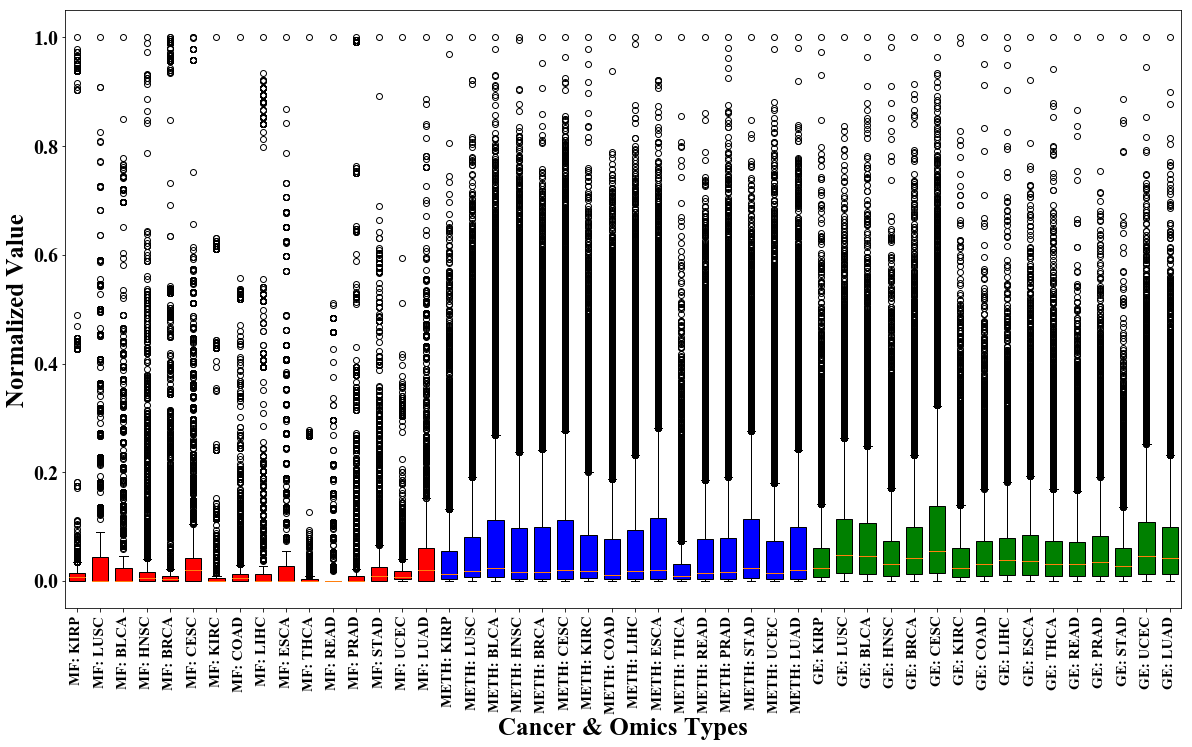

In [11]:
# plot distribution of features
fig = plt.figure(figsize=(20, 11))

# mutation frequencies
feat_names_mut = ['MF: ' + i.upper() for i in snvs_ppiindex.columns]

# gene expression
feat_names_ge = ['GE: ' + i.upper() for i in expression_ppiindex.columns]

# methylation
feat_names_meth = ['METH: ' + i.upper() for i in methylation_ppiindex.columns]

# CNAs
if cna_as_separate_omics:
    feat_names_cna = ['CNA: ' + i.upper() for i in cna_ppiindex.columns]
    feat_names_all = feat_names_mut + feat_names_meth + feat_names_ge + feat_names_cna
else:
    feat_names_all = feat_names_mut + feat_names_meth + feat_names_ge

# plot
x = plt.boxplot(multi_omics_features, widths=0.7, patch_artist=True)
_ = plt.xticks(range(1, multi_omics_features.shape[1]+1), feat_names_all, rotation='vertical', fontsize=15)
_ = plt.setp(plt.gca().get_yticklabels(), fontsize=20)

# fill with colors
colors = ['red']*len(feat_names_mut) + ['blue']*len(feat_names_meth) + ['green']*len(feat_names_ge) + ['orange']*len(feat_names_ge)
for patch, color in zip(x['boxes'], colors):
    patch.set_facecolor(color)

#plt.gca().set_ylim([-2, 2])
plt.xlabel('Cancer & Omics Types', fontsize=25)
plt.ylabel('Normalized Value', fontsize=25)
#plt.title('Distribution of Multi-Omics Data', fontsize=30)

#if use_quantile_norm:
#    fig.savefig('multi_omics_feature_distribution_quantiled.png', dpi=300)
#else:
#    fig.savefig('multi_omics_feature_distribution_normminmax.png', dpi=300)


Text(0, 0.5, 'Frequency')

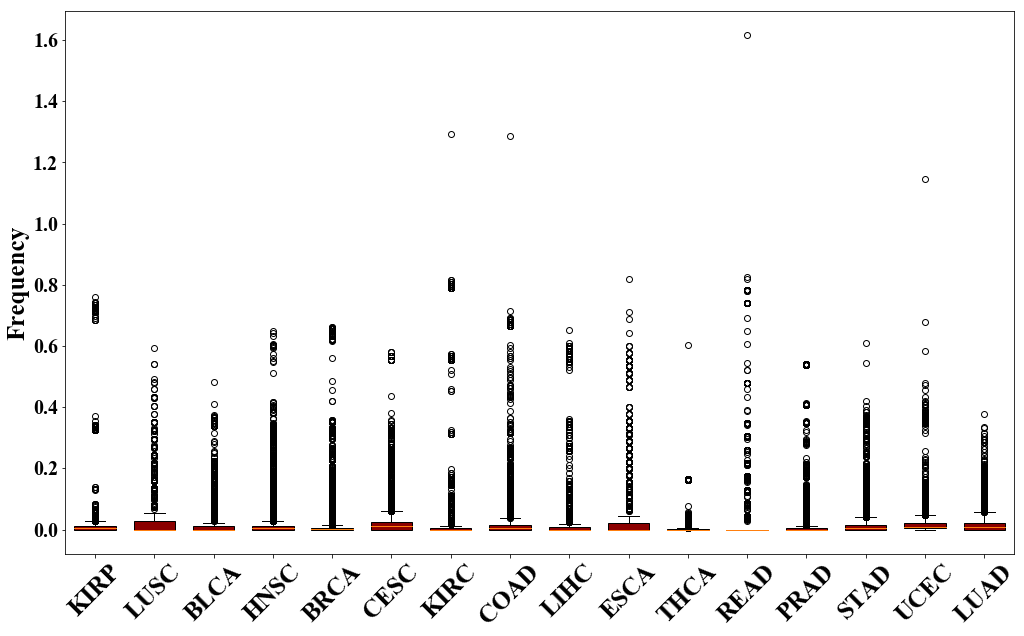

In [12]:
fig = plt.figure(figsize=(17, 10))

# plot
x = plt.boxplot(np.abs(snvs_ppiindex.values), widths=0.7, patch_artist=True)
_ = plt.xticks(range(1, snvs_ppiindex.shape[1]+1), [i.upper() for i in snvs_ppiindex.columns], rotation=45, fontsize=25)
_ = plt.setp(plt.gca().get_yticklabels(), fontsize=20)

colors = ['darkred']*len(feat_names_ge)
for patch, color in zip(x['boxes'], colors):
    patch.set_facecolor(color)

#plt.gca().set_ylim([-0.05, 2])
#plt.gca().set_ylim([-0.05, 1])
plt.xlabel('', fontsize=25)
#plt.ylabel('Frequency', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
#plt.title('Distribution of Multi-Omics Data', fontsize=30)
#fig.savefig('../../plots/input_ge.png', dpi=300)

Text(0, 0.5, 'Component 2')

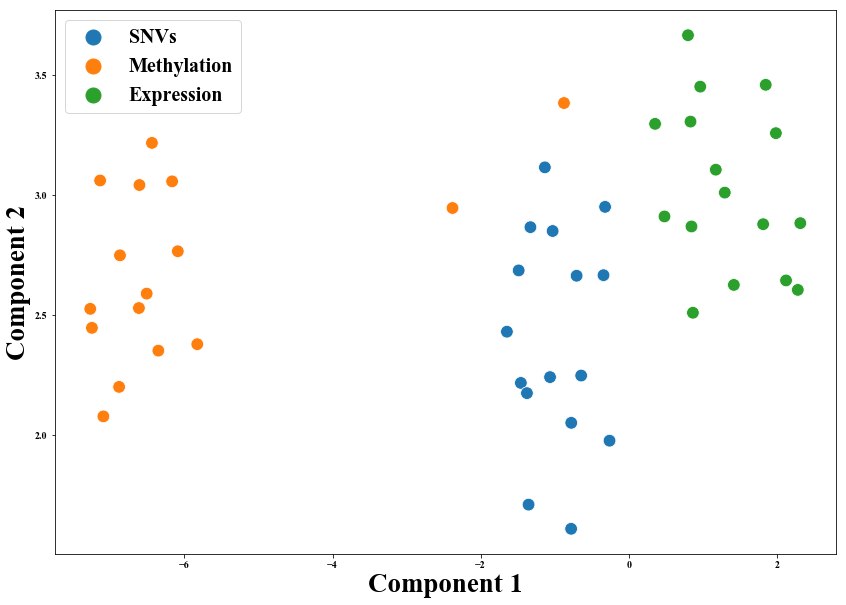

In [13]:
dim_red = umap.UMAP(n_components=2)
emb = dim_red.fit_transform(multi_omics_features.T)
fig = plt.figure(figsize=(14, 10))
emb_df = pd.DataFrame(emb)
if cna_as_separate_omics:
    cols = ['SNVs']*len(feat_names_mut) + ['Methylation']*len(feat_names_meth) + \
           ['Expression']*len(feat_names_ge) + ['CNAs']*len(feat_names_cna)
else:
    cols = ['SNVs']*len(feat_names_mut) + ['Methylation']*len(feat_names_meth) + \
       ['Expression']*len(feat_names_ge)
sns.scatterplot(x=emb[:, 0], y=emb[:, 1], s=160, hue=cols)
legend = plt.legend(prop={'size': 20}, markerscale=2.5)
plt.xlabel('Component 1', fontsize=27)
plt.ylabel('Component 2', fontsize=27)

### Correlation Matrix between Features

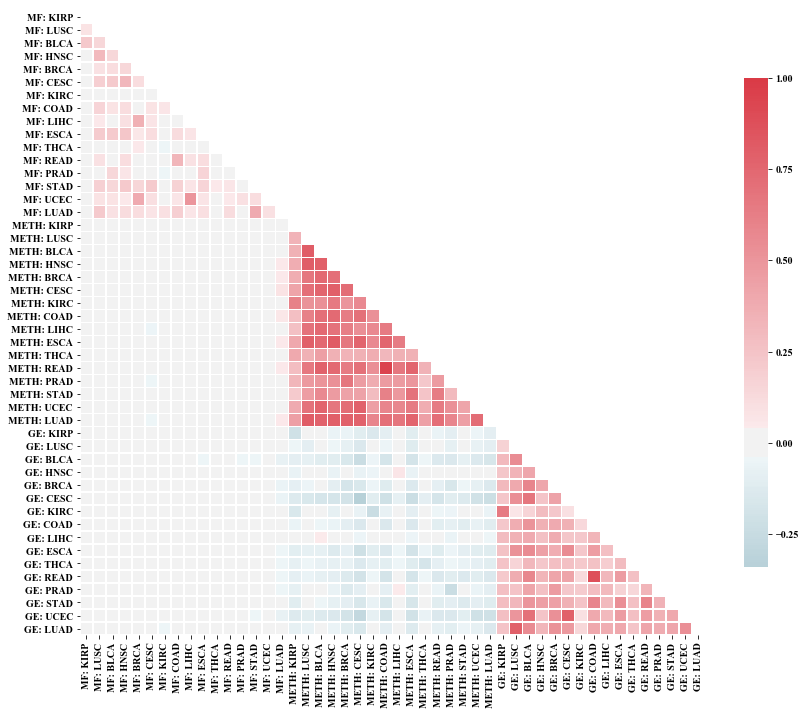

In [14]:
corr = pd.DataFrame(multi_omics_features_raw, index=ppi_network.index, columns=feat_names_all).corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#cmap = sns.color_palette("coolwarm")

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, cmap=cmap, center=0, xticklabels=True, yticklabels=True, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)
f.savefig('../../data/pancancer/TCGA/feature_correlation.svg')

## Get Labels

In [15]:
nodes = get_ensembl_ids(ppi_network.index)
nodes.head()

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-13178...done.
Finished.
10 input query terms found dup hits:
	[('MEMO1', 2), ('FKBP1C', 2), ('AHRR', 2), ('HBD', 2), ('TEC', 2), ('POLR2J3', 2), ('GPR21', 2), ('B


,Symbol
Ensembl_ID,
ENSG00000004059,ARF5
ENSG00000173898,SPTBN2
ENSG00000079616,KIF22
ENSG00000104671,DCTN6
ENSG00000105829,BET1


In [16]:
nodes.columns = ['Name']

ncg_known_cancer_genes = []
ncg_candidate_cancer_genes = []
n = 0
with open('../../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
    for line in f.readlines():
        n += 1
        if n == 1:
            continue
        l = line.strip().split('\t')
        if len(l) == 2:
            ncg_known_cancer_genes.append(l[0])
            ncg_candidate_cancer_genes.append(l[1])
        else:
            ncg_candidate_cancer_genes.append(l[0])

if label_source == 'NCG':
    known_cancer_genes_innet = nodes[nodes.Name.isin(ncg_known_cancer_genes)].Name
    #candidate_cancer_genes_innet = nodes[nodes.Name.isin(ncg_candidate_cancer_genes)].Name
    print (known_cancer_genes_innet.shape, len(ncg_known_cancer_genes))

elif label_source == 'expression':
    known_cancer_genes = []
    with open('../../data/pancancer/digSEE/expression/pan_cancer_genes.txt', 'r') as f:
        for line in f.readlines():
            known_cancer_genes.append(line.strip())
    known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
    print (known_cancer_genes_innet.shape)

elif label_source == 'methylation':
    known_cancer_genes = []
    with open('../../data/pancancer/digSEE/methylation/pan_cancer_genes.txt', 'r') as f:
        for line in f.readlines():
            known_cancer_genes.append(line.strip())
    known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
    print (known_cancer_genes_innet.shape)

elif label_source == 'mutation':
    known_cancer_genes = []
    with open('../../data/pancancer/digSEE/mutation/pan_cancer_genes.txt', 'r') as f:
        for line in f.readlines():
            known_cancer_genes.append(line.strip())
    known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
    print (known_cancer_genes_innet.shape)

elif label_source == 'all':
    # start with NCG genes
    known_cancer_genes = ncg_known_cancer_genes
    # add expression literature evidence (digSEE)
    with open('../../data/pancancer/digSEE/expression/pan_cancer_genes.txt', 'r') as f:
        for line in f.readlines():
            known_cancer_genes.append(line.strip())
    # add mutational literature evidence (digSEE)
    with open('../../data/pancancer/digSEE/mutation/pan_cancer_genes.txt', 'r') as f:
        for line in f.readlines():
            known_cancer_genes.append(line.strip())
    # add methylation literature evidence (digSEE)
    with open('../../data/pancancer/digSEE/methylation/pan_cancer_genes.txt', 'r') as f:
        for line in f.readlines():
            known_cancer_genes.append(line.strip())
    known_cancer_genes_innet = nodes[nodes.Name.isin(ncg_known_cancer_genes)].Name
    print (known_cancer_genes_innet.shape, len(known_cancer_genes))
else:
    print ("Label Source {} not understood.".format(label_source))

(785,) 990


In [17]:
if remove_blood_cancer_genes:
    # load cgc
    cgc = pd.read_csv('../../data/pancancer/cosmic/cancer_gene_census.csv')
    cgc.dropna(subset=['Tissue Type'], inplace=True)

    # find blood cancer genes based on these abbreviations (E=Epithelial, M=Mesenchymal, O=Other, L=Leukaemia/lymphoma)
    pattern = '|'.join(['E', 'O', 'M', 'E;'])
    non_blood_cancer_genes = cgc[cgc['Tissue Type'].str.contains(pattern)]
    blood_cancer_genes = cgc[~cgc['Tissue Type'].str.contains(pattern)]
    known_cancer_genes_innet = non_blood_cancer_genes[non_blood_cancer_genes['Gene Symbol'].isin(known_cancer_genes_innet)]['Gene Symbol']
    print ("Left with {} known cancer genes after blood removal".format(known_cancer_genes_innet.shape[0]))

In [18]:
print ("{} genes are in network".format(nodes.shape[0]))

# get rid of the positives (known cancer genes)
not_positives = nodes[~nodes.Name.isin(known_cancer_genes_innet)]
print ("{} genes are in network but not in positives (known cancer genes from NCG)".format(not_positives.shape[0]))

# get rid of OMIM genes associated with cancer
omim_cancer_genes = pd.read_csv('../../data/pancancer/OMIM/genemap_search_cancer.txt',
                                sep='\t', comment='#', header=0, skiprows=3)
# use fact that nan != nan for filtering out NaN
sublists = [sublist for sublist in omim_cancer_genes['Gene/Locus'].str.split(',') if sublist == sublist]
omim_cancer_geneset = [item.strip() for sublist in sublists for item in sublist]
not_omim_not_pos = not_positives[~not_positives.Name.isin(omim_cancer_geneset)]
print ("{} genes are also not in OMIM cancer genes".format(not_omim_not_pos.shape[0]))

# get rid of all the OMIM disease genes
omim_genes = pd.read_csv('../../data/pancancer/OMIM/genemap2.txt', sep='\t', comment='#', header=None)
omim_genes.columns = ['Chromosome', 'Genomic Position Start', 'Genomic Position End', 'Cyto Location',
                      'Computed Cyto Location', 'Mim Number', 'Gene Symbol', 'Gene Name',
                      'Approved Symbol', 'Entrez Gene ID', 'Ensembl Gene ID', 'Comments',
                      'Phenotypes', 'Mouse Gene Symbol/ID']
omim_gene_names = []
for idx, row in omim_genes.iterrows():
    gene_names = row['Gene Symbol'].strip().split(',')
    omim_gene_names += gene_names
omim_gene_names = list(set(omim_gene_names))
not_omim_not_pos = not_omim_not_pos[~not_omim_not_pos.Name.isin(omim_gene_names)]
print ("{} genes are in network but not in oncogenes and not in OMIM".format(not_omim_not_pos.shape[0]))


# remove COSMIC cancer gene census genes
cosmic_gene_scores = pd.read_csv('../../data/pancancer/cosmic/cancer_gene_census.csv', header=0)
not_omim_cosmic_pos = not_omim_not_pos[~not_omim_not_pos.Name.isin(cosmic_gene_scores['Gene Symbol'])]
print ("{} genes are also not in COSMIC cancer gene census".format(not_omim_cosmic_pos.shape[0]))

# remove COSMIC highly mutated genes
cosmic_prcoding_mutations = pd.read_csv('../../data/pancancer/cosmic/CosmicMutantExportCensus.tsv.gz',
                                        compression='gzip', sep='\t')
non_pos_omim_cosmiccgc_cosmic_mutated = not_omim_cosmic_pos[~not_omim_cosmic_pos.Name.isin(cosmic_prcoding_mutations['Gene name'])]
print ("{} genes are also not in COSMIC mutated genes".format(non_pos_omim_cosmiccgc_cosmic_mutated.shape[0]))

# remove genes that belong to KEGG pathways in cancer
kegg_cancer_pathway_genes = pd.read_csv('../../data/pancancer/KEGG/KEGG_genes_in_pathways_in_cancer.txt',
                                        skiprows=2, header=None, names=['Name'])
not_pos_omim_cosmic_kegg = non_pos_omim_cosmiccgc_cosmic_mutated[~non_pos_omim_cosmiccgc_cosmic_mutated.Name.isin(kegg_cancer_pathway_genes.Name)]
print ("{} genes are also not in KEGG cancer pathways".format(not_pos_omim_cosmic_kegg.shape[0]))

# get rid of genes that are not candidate cancer genes
negatives = not_pos_omim_cosmic_kegg[~not_pos_omim_cosmic_kegg.Name.isin(ncg_candidate_cancer_genes)]
print ("{} genes are also not in NCG candidate cancer genes".format(negatives.shape[0]))

"""
# collect genes in KEGG cancer modules
kegg_cancer_module_genes = []
count = 0
with open('../../data/pancancer/KEGG/KEGG_cancer_modules.gmt', 'r') as f:
    for line in f:
        for item in line.split('\t')[2:]:
            kegg_cancer_module_genes.append(item.strip())
kegg_cancer_module_genes = list(set(kegg_cancer_module_genes))

# collect genes in KEGG cancer gene neighborhoods
kegg_cancer_neighborhood_genes = []
count = 0
with open('../../data/pancancer/KEGG/KEGG_cancer_neighborhoods.gmt', 'r') as f:
    for line in f:
        for item in line.split('\t')[2:]:
            kegg_cancer_neighborhood_genes.append(item.strip())
kegg_cancer_neighborhood_genes = list(set(kegg_cancer_neighborhood_genes))

negatives = negatives[~negatives.Name.isin(kegg_cancer_module_genes) & ~negatives.Name.isin(kegg_cancer_neighborhood_genes)]
print ("{} genes also not in KEGG cancer modules or KEGG cancer gene neighborhoods".format(negatives.shape[0]))
"""

# remove very low degree genes to lower the bias
degrees_with_labels = pd.DataFrame(ppi_network.sum(), columns=['Degree'])
neg_w_degrees = degrees_with_labels[degrees_with_labels.index.isin(negatives.Name)]
negatives = negatives[negatives.Name.isin(neg_w_degrees[neg_w_degrees.Degree >= minimum_degree_negatives].index)]
print ("{} genes have a degree >= {}.".format(negatives.shape[0], minimum_degree_negatives))

13178 genes are in network
12393 genes are in network but not in positives (known cancer genes from NCG)
12373 genes are also not in OMIM cancer genes
2503 genes are in network but not in oncogenes and not in OMIM
2503 genes are also not in COSMIC cancer gene census
2503 genes are also not in COSMIC mutated genes
2498 genes are also not in KEGG cancer pathways
2342 genes are also not in NCG candidate cancer genes
2342 genes have a degree >= 1.


78.25987261146497 34.79760888129804


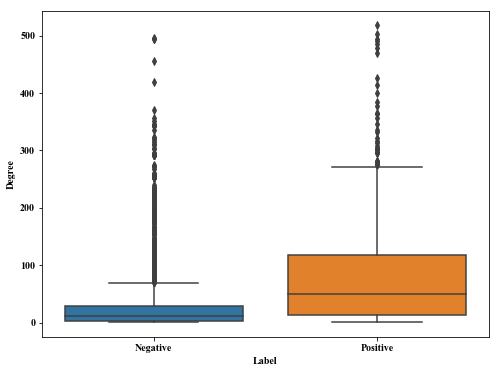

In [19]:
degrees_with_labels = pd.DataFrame(ppi_network.sum(), columns=['Degree'])
degrees_with_labels['Label'] = 'Unknown'
degrees_with_labels.loc[degrees_with_labels.index.isin(known_cancer_genes_innet), 'Label'] = 'Positive'
degrees_with_labels.loc[degrees_with_labels.index.isin(negatives.Name), 'Label'] = 'Negative'

fig = plt.figure(figsize=(8, 6))
sns.boxplot(data=degrees_with_labels[degrees_with_labels.Label.isin(['Positive', 'Negative'])],
            x='Label', y='Degree')
#plt.ylim([-5, 300])
print (degrees_with_labels[degrees_with_labels.index.isin(known_cancer_genes_innet)].Degree.mean(), degrees_with_labels[degrees_with_labels.index.isin(negatives.Name)].Degree.mean())

0.012777940554090568


/home/sasse/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


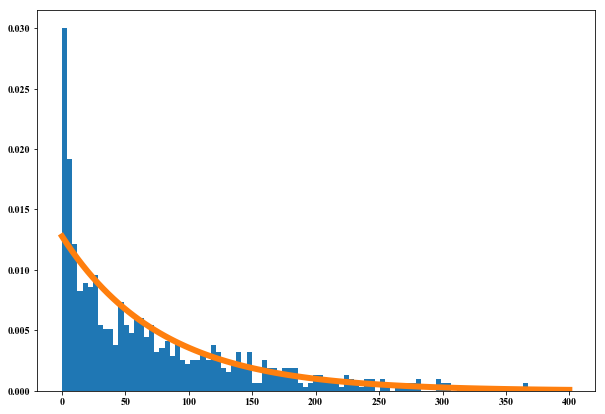

In [20]:
from scipy.stats import expon
fig = plt.figure(figsize=(10, 7))
x = np.linspace(0, 400, 100)
pos_degrees = degrees_with_labels[degrees_with_labels.Label == 'Positive'].Degree
_ = plt.hist(pos_degrees, bins=x, normed=True)
lam = 1./pos_degrees.mean()
eta = 0.01
print (lam)
plt.plot(x, lam * np.exp(-lam*x), lw=6)

In [21]:
all_negs = degrees_with_labels[degrees_with_labels.Label == 'Negative']
density_for_negs = lam * np.exp(-lam*all_negs.Degree)
density_for_negs.sort_values(ascending=True).head(10)

GNG7      0.000023
GNG3      0.000023
GNG8      0.000023
POLR2B    0.000038
ELOB      0.000060
EIF4A3    0.000113
H2AFX     0.000133
SNU13     0.000142
ANAPC1    0.000154
H2BFS     0.000156
Name: Degree, dtype: float64

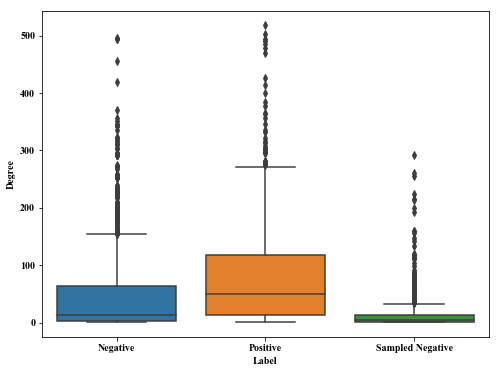

In [22]:
negs = all_negs.sample(n=1000, weights=density_for_negs)
degrees_with_labels.loc[degrees_with_labels.index.isin(negs.index), 'Label'] = 'Sampled Negative'
fig = plt.figure(figsize=(8, 6))
sns.boxplot(data=degrees_with_labels[degrees_with_labels.Label.isin(['Positive', 'Negative', 'Sampled Negative'])],
            x='Label', y='Degree')

In [23]:
negs.Degree.mean(), pos_degrees.mean(), degrees_with_labels[degrees_with_labels.Label == 'Negative'].Degree.mean()

(15.211, 78.25987261146497, 49.39269746646796)

## Do Training and Test Split

In [24]:
y = nodes.Name.isin(known_cancer_genes_innet).values.reshape(-1, 1)
mask = nodes.Name.isin(negatives.Name) | nodes.Name.isin(known_cancer_genes_innet)

In [25]:
y_train, train_mask, y_test, test_mask = gcnPreprocessing.train_test_split(y, mask, 0.25)
y_train, train_mask, y_val, val_mask = gcnPreprocessing.train_test_split(y_train, train_mask, 0.1)
y_train.sum(), train_mask.sum(), y_test.sum(), test_mask.sum(), y_val.sum(), val_mask.sum()

(530, 2110, 196, 782, 59, 235)

## Write back everything to container

In [26]:
def write_hdf5_container(fname, adj, F, node_names, y_train, y_val, y_test, train_mask, val_mask, test_mask, feature_names, features_raw):
    f = h5py.File(fname, 'w')
    string_dt = h5py.special_dtype(vlen=str)
    f.create_dataset('network', data=adj, shape=adj.shape)
    f.create_dataset('features', data=F, shape=F.shape)
    f.create_dataset('gene_names', data=node_names, dtype=string_dt)
    f.create_dataset('y_train', data=y_train, shape=y_train.shape)
    f.create_dataset('y_val', data=y_val, shape=y_val.shape)
    f.create_dataset('y_test', data=y_test, shape=y_test.shape)
    f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
    f.create_dataset('mask_val', data=val_mask, shape=val_mask.shape)
    f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
    f.create_dataset('feature_names', data=np.array(feature_names, dtype=object), dtype=string_dt)
    f.create_dataset('features_raw', data=features_raw, shape=features_raw.shape)
    f.close()

    print ("Container written to {}".format(fname))

In [27]:
nodes['ID'] = nodes.index
nodes = nodes[['ID', 'Name']]

fname = '../../data/pancancer/{}_multiomics.h5'.format(ppi_network_to_use.upper())
write_hdf5_container(fname, ppi_network.values, multi_omics_features, nodes, y_train,
                     y_val, y_test, train_mask, val_mask, test_mask, feat_names_all, multi_omics_features_raw)

Container written to ../../data/pancancer/STRING_multiomics.h5


## Write containers for leave-one-out omics
These are HDF5 containers in which one of the data types was left out.

In [28]:
if cna_as_separate_omics:
    # write data without SNVs
    no_snv_features = np.concatenate((meth_norm, ge_norm, cna_norm), axis=1)
    fname = '../../data/pancancer/{}_no_snvs.h5'.format(ppi_network_to_use)
    write_hdf5_container(fname, ppi_network.values, no_snv_features, nodes, y_train, y_val, y_test,
                         train_mask, val_mask, test_mask, feat_names_meth + feat_names_ge + feat_names_cna,
                         np.concatenate((methylation_ppiindex, expression_ppiindex, cna_ppiindex), axis=1))
    
    # write data without methylation
    no_meth_features = np.concatenate((mutfreq_norm, ge_norm, cna_norm), axis=1)
    fname = '../../data/pancancer/{}_no_meth.h5'.format(ppi_network_to_use)
    write_hdf5_container(fname, ppi_network.values, no_meth_features, nodes, y_train, y_val, y_test,
                     train_mask, val_mask, test_mask, feat_names_mut + feat_names_ge + feat_names_cna,
                     np.concatenate((snvs_ppiindex, expression_ppiindex, cna_ppiindex), axis=1))
    
    # write data without gene expression
    no_ge_features = np.concatenate((mutfreq_norm, meth_norm, cna_norm), axis=1)
    fname = '../../data/pancancer/{}_no_ge.h5'.format(ppi_network_to_use)
    write_hdf5_container(fname, ppi_network.values, no_ge_features, nodes, y_train, y_val, y_test,
                     train_mask, val_mask, test_mask, feat_names_mut + feat_names_meth + feat_names_cna,
                     np.concatenate((snvs_ppiindex, methylation_ppiindex, cna_ppiindex), axis=1))
    
    # write data without CNA
    no_cna_features = np.concatenate((mutfreq_norm, meth_norm, ge_norm), axis=1)
    fname = '../../data/pancancer/{}_no_cna.h5'.format(ppi_network_to_use)
    write_hdf5_container(fname, ppi_network.values, no_cna_features, nodes, y_train, y_val, y_test,
                     train_mask, val_mask, test_mask, feat_names_mut + feat_names_meth + feat_names_ge,
                     np.concatenate((snvs_ppiindex, methylation_ppiindex, expression_ppiindex), axis=1))
else:
    # write methylation + expression data
    meth_ge_features = np.concatenate((meth_norm, ge_norm), axis=1)
    fname = '../../data/pancancer/{}_methylation_expression.h5'.format(ppi_network_to_use)
    write_hdf5_container(fname, ppi_network.values, meth_ge_features, nodes, y_train, y_val, y_test,
                         train_mask, val_mask, test_mask, feat_names_meth + feat_names_ge,
                         np.concatenate((methylation_ppiindex, expression_ppiindex), axis=1))
    
    # write methylation + mutation data (SNV and or CNA)
    meth_mutfreq_features = np.concatenate((meth_norm, mutfreq_norm), axis=1)
    fname = '../../data/pancancer/{}_methylation_mutation.h5'.format(ppi_network_to_use)
    write_hdf5_container(fname, ppi_network.values, meth_mutfreq_features, nodes, y_train, y_val,
                         y_test, train_mask, val_mask, test_mask, feat_names_meth + feat_names_mut,
                         np.concatenate((methylation_ppiindex, snvs_ppiindex), axis=1))
    
    # write mutation (SNV and/or CNA) + expression data
    mutfreq_ge_features = np.concatenate((mutfreq_norm, ge_norm), axis=1)
    fname = '../../data/pancancer/{}_mutation_expression.h5'.format(ppi_network_to_use)
    write_hdf5_container(fname, ppi_network.values, mutfreq_ge_features, nodes, y_train, y_val,
                         y_test, train_mask, val_mask, test_mask, feat_names_mut + feat_names_ge,
                         np.concatenate((snvs_ppiindex, expression_ppiindex), axis=1))

Container written to ../../data/pancancer/STRING_methylation_expression.h5
Container written to ../../data/pancancer/STRING_methylation_mutation.h5
Container written to ../../data/pancancer/STRING_mutation_expression.h5


## Write out single omics combinations

In [29]:
fname = '../../data/pancancer/{}_mutations.h5'.format(ppi_network_to_use)
write_hdf5_container(fname, ppi_network.values, mutfreq_norm, nodes, y_train,
                     y_val, y_test, train_mask, val_mask, test_mask, feat_names_mut, snvs_ppiindex)

Container written to ../../data/pancancer/STRING_mutations.h5


In [30]:
fname = '../../data/pancancer/{}_methylation.h5'.format(ppi_network_to_use)
write_hdf5_container(fname, ppi_network.values, meth_norm, nodes, y_train,
                     y_val, y_test, train_mask, val_mask, test_mask, feat_names_meth, methylation_ppiindex)

Container written to ../../data/pancancer/STRING_methylation.h5


In [31]:
fname = '../../data/pancancer/{}_expression.h5'.format(ppi_network_to_use)
write_hdf5_container(fname, ppi_network.values, ge_norm, nodes, y_train,
                     y_val, y_test, train_mask, val_mask, test_mask, feat_names_ge, expression_ppiindex)

Container written to ../../data/pancancer/STRING_expression.h5


In [32]:
if cna_as_separate_omics:
    fname = '../../data/pancancer/{}_cnas.h5'.format(ppi_network_to_use)
    write_hdf5_container(fname, ppi_network.values, cna_norm, nodes, y_train,
                         y_val, y_test, train_mask, val_mask, test_mask, feat_names_cna, cna_ppiindex)